This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/advanced/advanced_002.ipynb).

# Advanced tutorial 2: Detailed analysis of the QDET many-body states

In this tutorial, we show how the full diagonalization of effective Hamiltonian in QDET enables a detailed analysis of the excited states of the defect.

As we focus on the analysis in this tutorial, we download the input and output files from the QDET calculation. For more details about how to perform the underlying QDET calculations, see [Basic Tutorial 5](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_005.ipynb).

In [1]:
%%bash
mkdir -p west.wfreq.save
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/wfreq.in
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/wfreq.json -O west.wfreq.save/wfreq.json

We diagonalize the QDET Hamiltonian as usual:

In [2]:
from westpy.qdet import QDETResult

# construct object for effective Hamiltonian
effective_hamiltonian = QDETResult(filename='west.wfreq.save/wfreq.json')

# diagonalize Hamiltonian
solution = effective_hamiltonian.solve()

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.2.0
Today            :  2022-12-13 13:04:28.462881
-----------------------------------------------------
Building effective Hamiltonian...
nspin: 1
occupations: [[2. 2. 2. 2. 1. 1.]]


diag[1RDM - 1RDM(GS)]                                 
  E [eV] char                    87    122    123    126   127   128
0  0.000   3-                 0.000  0.000  0.000  0.000 0.000 0.000
1  0.436   1-                -0.001 -0.009 -0.018 -0.067 0.037 0.058
2  0.436   1-                -0.001 -0.009 -0.018 -0.067 0.058 0.037
3  1.250   1-                -0.002 -0.019 -0.023 -0.067 0.056 0.055
4  1.941   3-                -0.003 -0.010 -0.127 -0.860 0.000 1.000
5  1.941   3-                -0.003 -0.010 -0.127 -0.860 1.000 0.000
6  2.937   1-                -0.000 -0.032 -0.043 -0.855 0.110 0.821
7  2.937   1-                -0.000 -0.033 -0.043 -0.855 0.821 0.109
8  4.662   1-                -0.005 -0.055 -0.188 -1.672 0.960 0.960
9  5.073   3-                -0.014 -0.702 -0.209 -0.075 0.000 1.000

-----------------------------------------------------


The solution that was just found was obtained for the following number of electrons in number of orbitals

In [3]:
print(solution['nelec'])
print(solution['norb'])

(5, 5)
6


The number of electrons can be compared with the `basis` and `occupation` stored in the effective Hamiltonian.

In [4]:
print(effective_hamiltonian.basis)
print(len(effective_hamiltonian.basis))

[ 87 122 123 126 127 128]
6


In [5]:
import numpy as np
print(effective_hamiltonian.occupation)
print(np.sum(effective_hamiltonian.occupation))

[[2. 2. 2. 2. 1. 1.]]
10.0


This is the case of solutions with $M_S=0$. We will later discuss the case with $M_S=1$.

To check for the value of $S^2$ and spin multiplicity, one can easily:

In [6]:
import pyscf
fcisolver = pyscf.fci.direct_spin1.FCISolver()

for i, state in enumerate(solution['evcs']):
    en = solution['evs'][i]
    ss, mult = fcisolver.spin_square(state, norb=solution['norb'], nelec=solution['nelec'])
    print(f"i={i}, energy [eV]={en:.3f}, <S^2>={ss:.3f}, mult={mult:.3f}")

i=0, energy [eV]=0.000, <S^2>=2.000, mult=3.000
i=1, energy [eV]=0.436, <S^2>=0.000, mult=1.000
i=2, energy [eV]=0.436, <S^2>=0.000, mult=1.000
i=3, energy [eV]=1.250, <S^2>=0.000, mult=1.000
i=4, energy [eV]=1.941, <S^2>=2.000, mult=3.000
i=5, energy [eV]=1.941, <S^2>=2.000, mult=3.000
i=6, energy [eV]=2.937, <S^2>=0.000, mult=1.000
i=7, energy [eV]=2.937, <S^2>=0.000, mult=1.000
i=8, energy [eV]=4.662, <S^2>=0.000, mult=1.000
i=9, energy [eV]=5.073, <S^2>=2.000, mult=3.000


The eigenstate of each many-body state is a matrix of size (No. of Slater determinants in the spin-alpha channel, No. of Slater determinants in the spin-beta channel), where each entry represents the contribution of that product of Slater determinants to the many-body states. We can easily determine the number of Slater determinants in each spin-channel as follows:

In [7]:
from pyscf.fci import cistring

# print the number of possible Slater determinants in each spin channel
for ispin, spinlabel in enumerate(['alpha','beta']):
    print(f'No. Slater determinants in spin-channel {spinlabel} = {len(cistring.make_strings(range(solution["norb"]),solution["nelec"][ispin]))}')

No. Slater determinants in spin-channel alpha = 6
No. Slater determinants in spin-channel beta = 6


We check that the shape of the eigenvector matrix is 6x6

In [8]:
print(solution['evcs'][0].shape)

(6, 6)


We can now inspect the contribution of the various Slater determinants to a given excited many-body state.

In [9]:
from westpy.qdet import visualize_correlated_state

for i, state in enumerate(solution['evcs']):
    en = solution['evs'][i]
    print(f'i= {i}, en [eV]={en}, ',visualize_correlated_state(state, solution['norb'], solution['nelec'], cutoff=10 **(-3)))
    print( )

i= 0, en [eV]=0.0,  -0.707|011111>|101111>+0.707|101111>|011111>

i= 1, en [eV]=0.43604350252126883,  +0.129|011111>|011111>-0.660|011111>|101111>-0.114|011111>|110111>+0.059|011111>|111011>-0.041|011111>|111101>+0.014|011111>|111110>-0.660|101111>|011111>-0.129|101111>|101111>+0.144|101111>|110111>-0.074|101111>|111011>+0.051|101111>|111101>-0.017|101111>|111110>-0.114|110111>|011111>+0.144|110111>|101111>+0.059|111011>|011111>-0.074|111011>|101111>-0.041|111101>|011111>+0.051|111101>|101111>+0.014|111110>|011111>-0.017|111110>|101111>

i= 2, en [eV]=0.4361351159418135,  +0.660|011111>|011111>+0.129|011111>|101111>+0.144|011111>|110111>-0.074|011111>|111011>+0.051|011111>|111101>-0.017|011111>|111110>+0.129|101111>|011111>-0.660|101111>|101111>+0.114|101111>|110111>-0.059|101111>|111011>+0.041|101111>|111101>-0.014|101111>|111110>+0.144|110111>|011111>+0.114|110111>|101111>-0.074|111011>|011111>-0.059|111011>|101111>+0.051|111101>|011111>+0.041|111101>|101111>-0.017|111110>|011111>-0.

The ground state is a linear combination of products of two Slater determinants, such as $|011111\rangle| 101111\rangle$, where the first one ($|011111\rangle$) is the Slater determinant in the alpha-channel, and the second one ($|101111\rangle$) is the determinant in the beta-channel.

Slater determinants are in the Fock-representation, where the orbitals with the lowest energy is on the right. For example, $|011111\rangle$ means that the 5 orbitals with lowest energy are occupied and the orbital with highest energy is unoccupied.

Finally, the `cutoff` in `visualize_correlated_state` is the cutoff for Slater determinants. Only Slater determinants with prefactors larger (in abs value) than the cutoff are printed.

We can visualize the contribution of the various Slater determinants to a given excited many-body state.

<IPython.core.display.Javascript object>


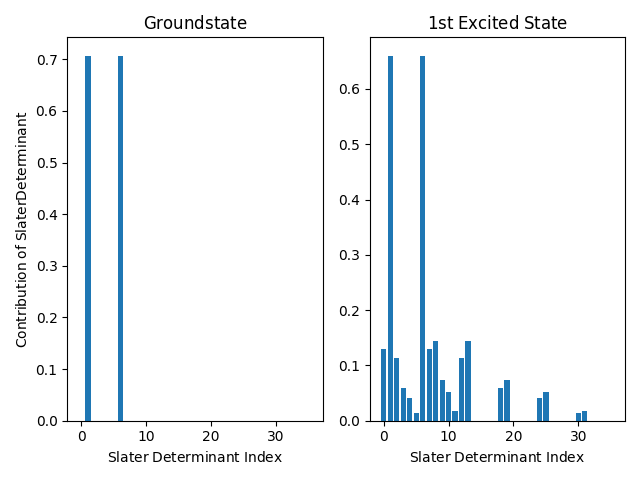

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

index1 = 0
index2 = 1

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(r'$\mathrm{Groundstate}$')
ax2.set_title(r'$\mathrm{1st \; Excited \; State}$')

ax1.set_xlabel(r'$\mathrm{Slater \; Determinant \; Index}$')
ax1.set_ylabel(r'$\mathrm{Contribution \; of \; Slater Determinant}$')

ax2.set_xlabel(r'$\mathrm{Slater \; Determinant \; Index}$')


ax1.bar([i for i in range(solution['evcs'][index1].flatten().shape[0])],
        abs(solution['evcs'][index1].flatten()))

ax2.bar([i for i in range(solution['evcs'][index2].flatten().shape[0])],
        abs(solution['evcs'][index2].flatten()))

plt.tight_layout()
plt.show()

## Solution of QDET for $Ms=1$

We demonstate how to diagonalize the effective Hamiltonian for $M_S=1$. In this case the number of electrons in the alpha spin cannel will be > than the number of electrons in the beta spin-channel.

We re-download the dataset obtained with WEST.

In [11]:
%%bash
mkdir -p west.wfreq.save
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/wfreq.in
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/wfreq.json -O west.wfreq.save/wfreq.json

We now diagonalize the effective Hamiltonian choosing manually the number of electrons.

In [12]:
from westpy.qdet import QDETResult

# construct object for effective Hamiltonian
effective_hamiltonian = QDETResult(filename='west.wfreq.save/wfreq.json')


nelec=(int(np.sum(effective_hamiltonian.occupation)//2)+1,int(np.sum(effective_hamiltonian.occupation)//2)-1)
print(nelec)

# diagonalize Hamiltonian
solution = effective_hamiltonian.solve(nelec=nelec)

(6, 4)
-----------------------------------------------------
Building effective Hamiltonian...
nspin: 1
occupations: [[2. 2. 2. 2. 1. 1.]]


diag[1RDM - 1RDM(GS)]                                 
  E [eV] char                    87    122    123    126   127   128
0  0.000   3-                 0.000  0.000  0.000  0.000 0.000 0.000
1  1.941   3-                -0.003 -0.010 -0.127 -0.860 0.000 1.000
2  1.941   3-                -0.003 -0.010 -0.127 -0.860 1.000 0.000
3  5.073   3-                -0.014 -0.702 -0.209 -0.075 0.000 1.000
4  5.073   3-                -0.014 -0.702 -0.209 -0.075 1.000 0.000
5  6.159   3-                -0.001 -0.274 -0.660 -0.065 0.007 0.993
6  6.160   3-                -0.001 -0.274 -0.660 -0.065 0.993 0.007
7  7.024   3-                -0.017 -0.695 -0.349 -0.938 1.000 1.000
8  8.013   3-                -0.003 -0.299 -0.765 -0.933 1.000 1.000
9 11.127   3-                -0.019 -0.976 -0.877 -0.128 1.000 1.000

-----------------------------------------------------


We see that we have found only triplet states. In order to find singlet and triplet states it is therefore necessary to have $M_S=0$, which is the assumption that is made by default in the `solve` method.